# Final Results: IMDb Ratings

Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
import matplotlib
import matplotlib.pyplot as plt
import math
import StringIO
import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn import svm
from sklearn.dummy import DummyClassifier as Dummy
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
%matplotlib inline

/Users/kyledevine/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# read in movie data and remove rows with missing column data
movie_data = pd.read_csv('movie_metadata.csv')
movie_data = movie_data[np.isfinite(movie_data['budget'])]
movie_data = movie_data[np.isfinite(movie_data['duration'])]
movie_data = movie_data[np.isfinite(movie_data['gross'])]
movie_data = movie_data[np.isfinite(movie_data['title_year'])]
movie_data = movie_data[np.isfinite(movie_data['cast_total_facebook_likes'])]
movie_data = movie_data[np.isfinite(movie_data['imdb_score'])]

# create genre list
genre_list = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'History', 'Horror', 'Mystery', 'Romance']

# create categorical variables for these common genres
for genre in genre_list:
    lst = []
    for index, row in movie_data.iterrows():
        if (row['genres']).find(genre) != -1:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[genre] = lst

In [4]:
# create list of most common directors
counts = pd.value_counts(movie_data['director_name'])
counts = counts[counts > 6]

directors = counts.index.tolist()
print "Number of Directors: ", len(directors)

Number of Directors:  91


In [6]:
# create a list of most common actors
counts_actors = pd.value_counts(movie_data['actor_1_name'])
counts_actors = counts_actors[counts_actors > 7]

actors = counts_actors.index.tolist()
print "Number of Actors: ", len(actors)

Number of Actors:  97


In [7]:
# create categorical column for each director
for director in directors:
    lst = []
    for _, row in movie_data.iterrows():
        if row['director_name'] == director:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[director] = lst

In [8]:
# create categorical column for each actor
for actor in actors:
    lst = []
    for _, row in movie_data.iterrows():
        if row['actor_1_name'] == actor or row['actor_2_name'] == actor or row['actor_3_name'] == actor:
            lst.append(1)
        else:
            lst.append(0)
    movie_data[actor] = lst

In [103]:
# get list of inflation rates
inf = np.loadtxt('inf.csv')
budget_inf = []
gross_inf = []

# get log-10 values for each budget value and each row values
for _, row in movie_data.iterrows():
    budget = math.log10(row['budget'])
    gross = math.log10(row['gross'])
    budget_inf.append(budget)
    gross_inf.append(gross)

# create columns for these log values
movie_data['budget_inf'] = budget_inf
movie_data['gross_inf'] = gross_inf

In [106]:
# create new dataframe
train_test = pd.DataFrame({})

# add columns to be used for regression
train_test = pd.concat([train_test, movie_data[genre]], axis = 1)
train_test = pd.concat([train_test, movie_data[directors]], axis = 1)
train_test = pd.concat([train_test, movie_data[actors]], axis = 1)
train_test = pd.concat([train_test, movie_data['budget_inf']], axis = 1)
train_test = pd.concat([train_test, movie_data['imdb_score']], axis = 1)
train_test = pd.concat([train_test, movie_data['duration']], axis = 1)
train_test = pd.concat([train_test, pd.get_dummies(movie_data['content_rating'])], axis = 1)

# create and split training and testing groups
training, testing = sklearn.model_selection.train_test_split(train_test, train_size = 0.4, test_size = 0.6)

# create and fit ridge regression model
rr_model = Ridge(alpha = 6)
rr_model.fit(training.drop('imdb_score', axis=1), training['imdb_score'])

# print scores
print "Ridge Regression Model on Training Set:", rr_model.score(training.drop('imdb_score', axis = 1), training['imdb_score'])
print "Ridge Regression Model on Testing Set:", rr_model.score(testing.drop('imdb_score', axis = 1), testing['imdb_score'])

Ridge Regression Model on Training Set: 0.330662947591
Ridge Regression Model on Testing Set: 0.301741905274


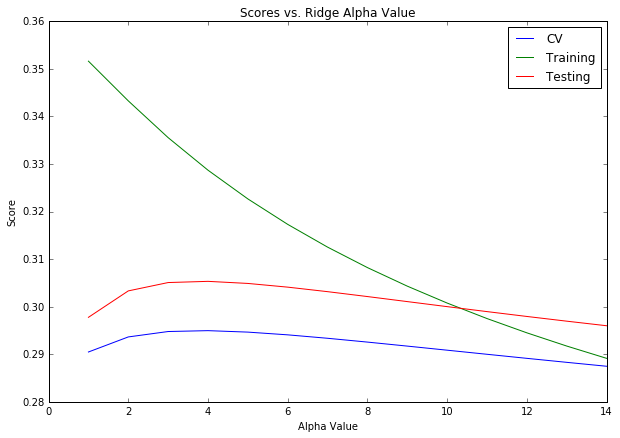

In [71]:
# create list to keep tracks of scores
cv_list = []
test_scores = []
train_scores = []

# shuffle values before CV
train_test_shuffled = shuffle(train_test)

# for each alpha value, score models
for i in range(1,15):
    rr_model = Ridge(alpha = i)
    cv_scores = cross_val_score(rr_model, train_test_shuffled.drop('imdb_score', axis=1), train_test_shuffled['imdb_score'], cv = 4)
    cv_list.append(np.mean(cv_scores))
    
    rr_model.fit(training.drop('imdb_score', axis=1), training['imdb_score'])
    
    train_scores.append(rr_model.score(training.drop('imdb_score', axis=1), training['imdb_score']))
    test_scores.append(rr_model.score(testing.drop('imdb_score', axis=1), testing['imdb_score']))

# plot scores
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(211)
ax1.plot(range(1,15), cv_list, label= 'CV')
ax1.plot(range(1,15), train_scores, c = 'g', label = 'Training')
ax1.plot(range(1,15), test_scores, c='r', label = 'Testing')
ax1.set_title('Scores vs. Ridge Alpha Value')
ax1.set_xlabel('Alpha Value')
ax1.set_ylabel('Score')
ax1.legend()

In [118]:
# create classes for score
lst = []
for index, row in movie_data.iterrows():
        if row['imdb_score'] > 8.5:
            lst.append(5)
        elif row['imdb_score'] > 7.5:
            lst.append(4)
        elif row['imdb_score'] > 6.0:
            lst.append(3)
        elif row['imdb_score'] > 5.0: 
            lst.append(2)
        else:
            lst.append(1)

movie_data['quality_class'] = lst

In [156]:
# create dataframe for variables
train_test = pd.DataFrame({})


train_test = pd.concat([train_test, movie_data[genre_list]], axis = 1)
train_test = pd.concat([train_test, movie_data[directors]], axis = 1)
train_test = pd.concat([train_test, movie_data[actors]], axis = 1)
train_test = pd.concat([train_test, movie_data['budget_inf']], axis = 1)
train_test = pd.concat([train_test, movie_data['duration']], axis = 1)
train_test = pd.concat([train_test, movie_data['quality_class']], axis = 1)
train_test = pd.concat([train_test, pd.get_dummies(movie_data['content_rating'])], axis = 1)

# split data
training, testing = sklearn.model_selection.train_test_split(train_test, train_size = 0.4, test_size = 0.6)



In [157]:
# score dummy model for imdb class
print "IMDB score class"
d_model = Dummy()
d_model.fit(training.drop('quality_class', axis=1), training['quality_class'])
print "\tDummy Model", d_model.score(testing.drop('quality_class', axis = 1), testing['quality_class'])

# create random forest classifier
rfc_model = RFC(max_depth=6, n_estimators=10)
rfc_model.fit(training.drop('quality_class', axis=1), training['quality_class'])

print "\tRandom Forest Classifier Model", rfc_model.score(testing.drop('quality_class', axis = 1), testing['quality_class'])

IMDB score class
	Dummy Model 0.357754927164
	Random Forest Classifier Model 0.554841473865
